In [1]:
!pip install -q /input/loguru-lib-ds/loguru-0.5.3-py3-none-any.whl
!pip install -q /input/bbox-lib-ds

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [2]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
sys.path.append('/input/tensorflow-great-barrier-reef')
import torch
from PIL import Image

In [3]:
ROOT_DIR  = '/input/tensorflow-great-barrier-reef/'
# CKPT_DIR  = '/kaggle/input/greatbarrierreef-yolov5-train-ds'
CKPT_PATH = '/input/reef-baseline-fold12/l6_3600_uflip_vm5_f12_up/f1/best.pt' # by @steamedsheep
IMG_SIZE  = 9000
CONF      = 0.25
IOU       = 0.40
AUGMENT   = True

In [4]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df['image_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                          image_path  
0  /kaggle/input/tensorflow-great-barrier-reef//t...  
1  /kaggle/input/tensorflow-great-barrier-reef//t...

In [5]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts()/len(df)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [6]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
from bbox.utils import coco2yolo, coco2voc, voc2yolo, voc2coco
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

In [7]:
!mkdir -p /root/.config/Ultralytics
!cp /input/yolov5-font/Arial.ttf /root/.config/Ultralytics/

In [8]:
def load_model(ckpt_path, conf=0.25, iou=0.50):
    model = torch.hub.load('/input/yolov5-lib-ds',
                           'custom',
                           path=ckpt_path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model

In [9]:
def predict(model, img, size=768, augment=False):
    height, width = img.shape[:2]
    results = model(img, size=size, augment=augment)  # custom inference size
    preds   = results.pandas().xyxy[0]
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        confs   = preds.confidence.values
        return bboxes, confs
    else:
        return [],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

YOLOv5 🚀 2025-8-18 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients
Adding AutoShape... 


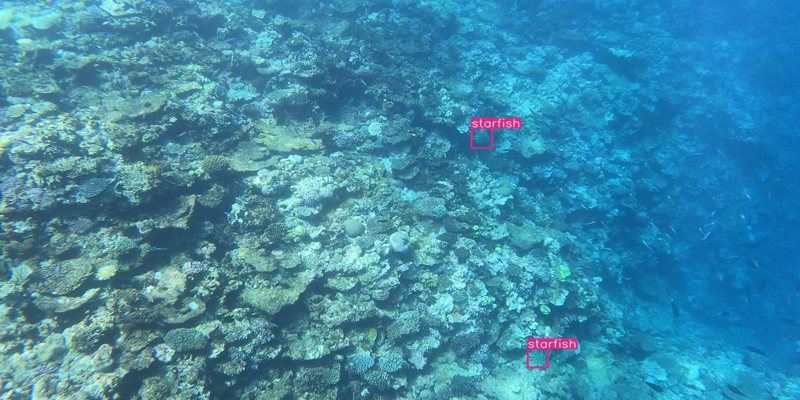

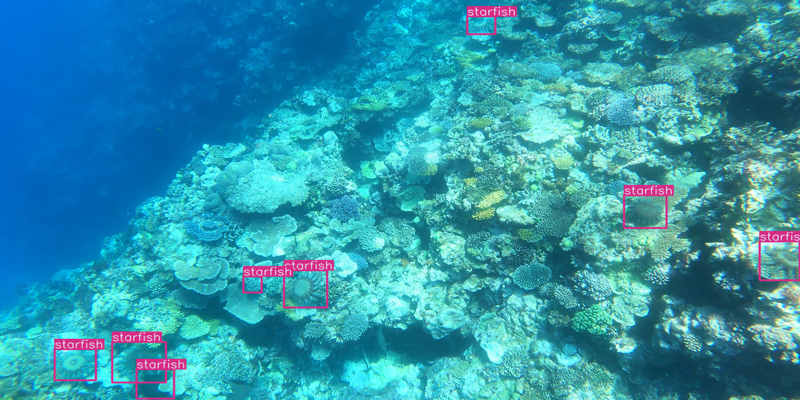

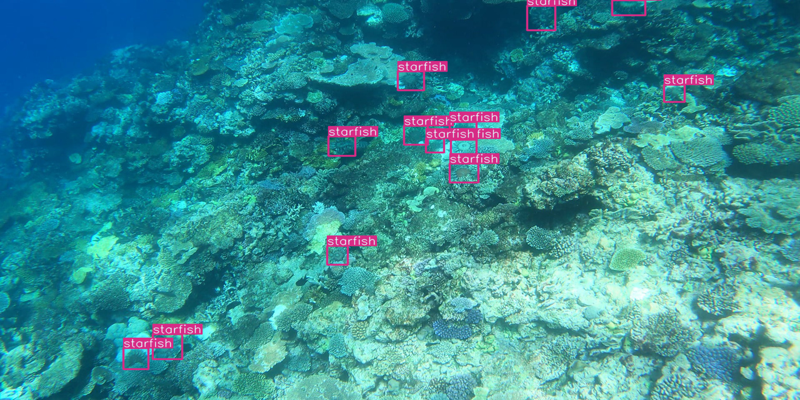

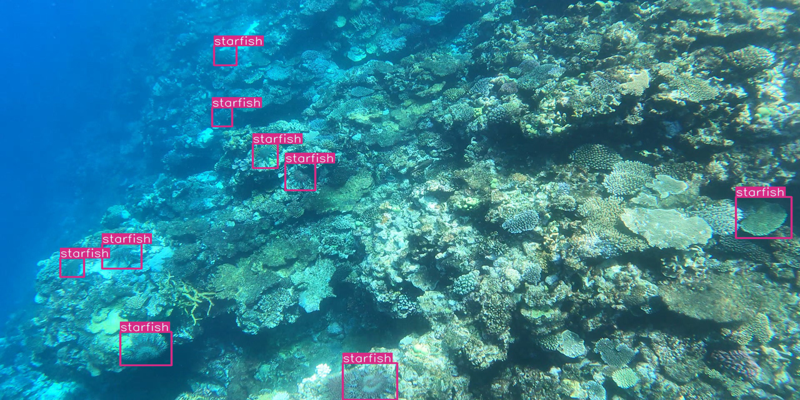

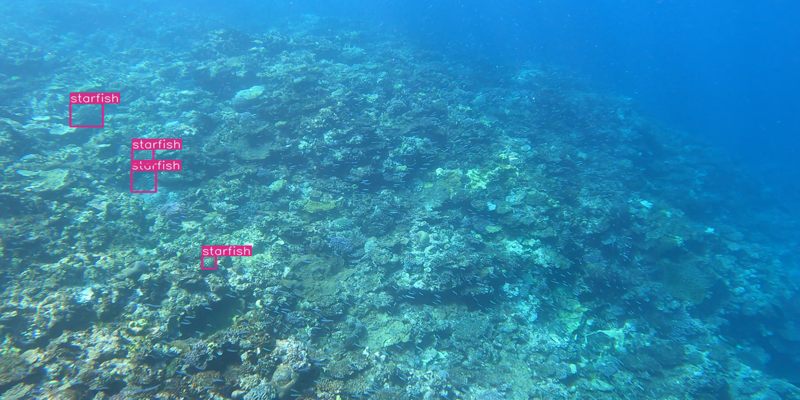

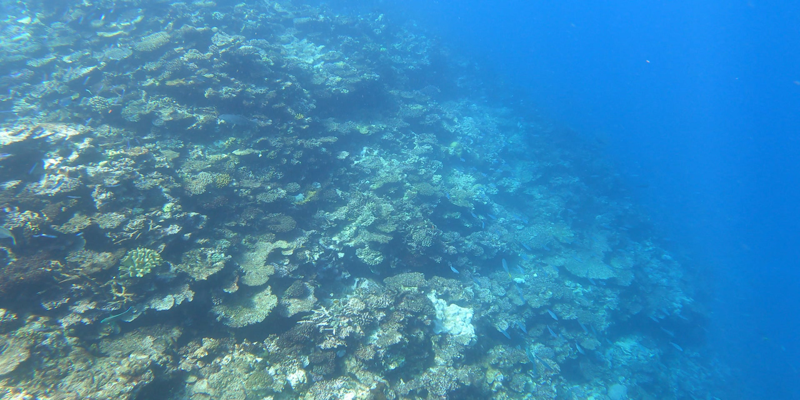

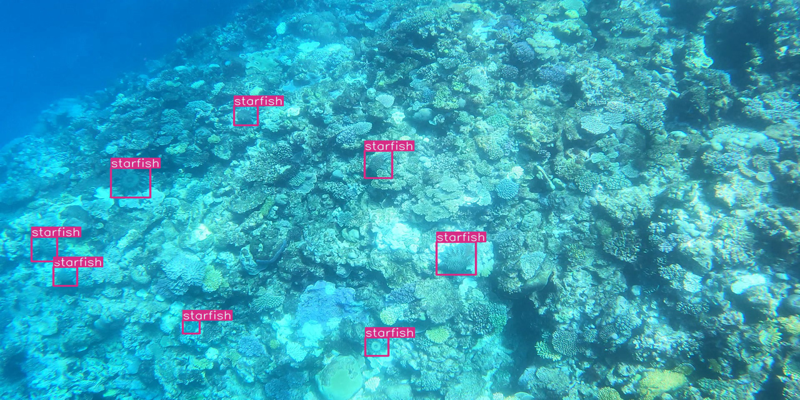

In [10]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
image_paths = df[df.num_bbox>1].sample(100).image_path.tolist()
frames = []  # Added to collect annotated frames for video
for idx, path in enumerate(image_paths):
    img = cv2.imread(path)[...,::-1]
    bboxes, confis = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    annotated_img = draw_bboxes(img=img.copy(), bboxes=bboxes, classes=['starfish']*len(bboxes),
                                class_ids=[0]*len(bboxes), class_name=True, colors=colors,
                                bbox_format='coco', line_thickness=2)
    frames.append(annotated_img)
    display(Image.fromarray(annotated_img).resize((800, 400)))
    if idx>5:
        break

In [11]:
# Added code to create video from collected frames
if frames:
    height, width = frames[0].shape[:2]
    video_path = 'validation_video.mp4'
    out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))  # 1 FPS
    for frame in frames:
        out.write(frame[..., ::-1])  # Convert RGB to BGR for OpenCV
    out.release()
    print(f"Validation video saved at {video_path}")

YOLOv5 🚀 2025-8-18 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model Summary: 280 layers, 12308200 parameters, 0 gradients
Adding AutoShape... 


0it [00:00, ?it/s]

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


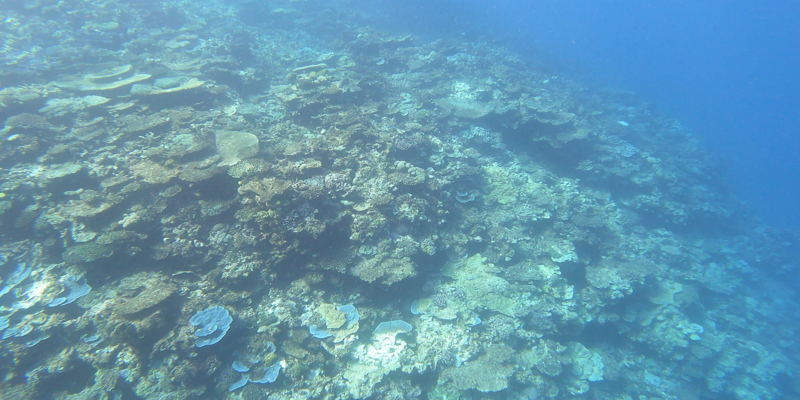

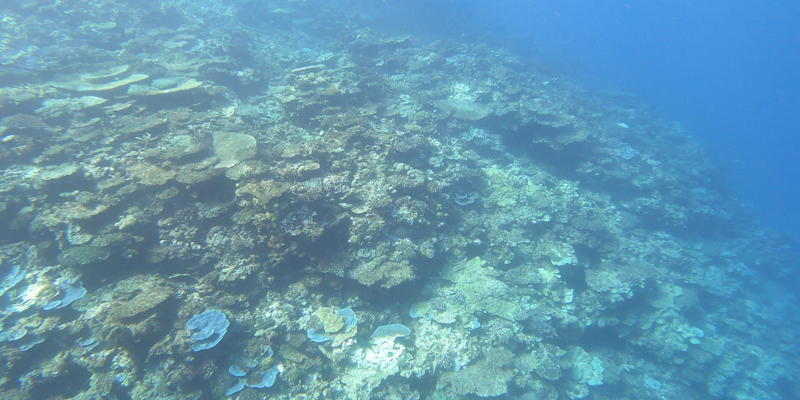

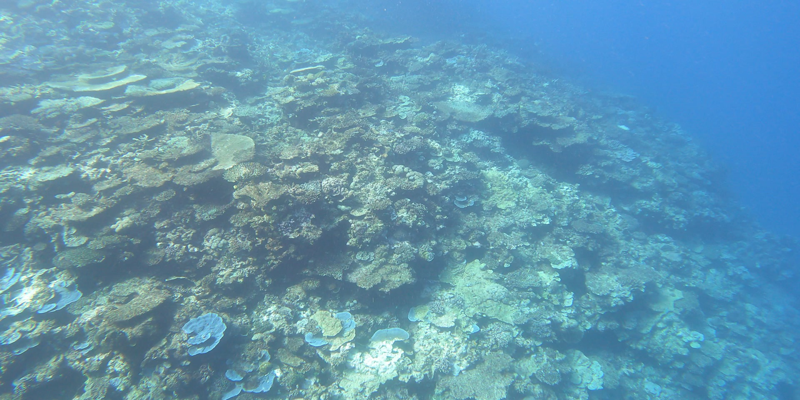

In [12]:
import greatbarrierreef
env = greatbarrierreef.make_env()# initialize the environment
iter_test = env.iter_test()

In [ ]:
model = load_model(CKPT_PATH, conf=CONF, iou=IOU)
test_frames = []  # Added to collect annotated test frames for video
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    bboxes, confs  = predict(model, img, size=IMG_SIZE, augment=AUGMENT)
    annot          = format_prediction(bboxes, confs)
    pred_df['annotations'] = annot
    env.predict(pred_df)
    annotated_img = draw_bboxes(img=img.copy(), bboxes=bboxes, classes=['starfish']*len(bboxes),
                                class_ids=[0]*len(bboxes), class_name=True, colors=colors,
                                bbox_format='coco', line_thickness=2)
    test_frames.append(annotated_img)
    if idx<3:
        display(Image.fromarray(annotated_img).resize((800, 400)))

In [ ]:
# Added code to create video from collected test frames
if test_frames:
    height, width = test_frames[0].shape[:2]
    test_video_path = 'test_video.mp4'
    out = cv2.VideoWriter(test_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))  # 1 FPS
    for frame in test_frames:
        out.write(frame[..., ::-1])  # Convert RGB to BGR for OpenCV
    out.release()
    print(f"Test video saved at {test_video_path}")